In [4]:
import pandas as pd
import numpy as np
import json
import keras
import random
from keras.layers import Dense, LSTM, Dropout, Masking
from keras.models import Sequential, load_model
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
import os

Using TensorFlow backend.


In [2]:
with open('../dati/pad/lines_pad.json', 'r') as f:
    data_lines = json.load(f)

with open('../dati/pad/lines_2_pad.json', 'r') as f:
    data_lines += json.load(f)

for elem in range(len(data_lines)):
    for arr in range(len(data_lines[elem])):
        tmp = []
        for f in range(7):
            tmp.append(data_lines[elem][arr][f])
        data_lines[elem][arr] = tmp

In [3]:
with open('../dati/pad/circles_pad.json', 'r') as f:
    data_circles = json.load(f)

for elem in range(len(data_circles)):
    for arr in range(len(data_circles[elem])):
        tmp = []
        for f in range(7):
            tmp.append(data_circles[elem][arr][f])
        data_circles[elem][arr] = tmp
        

In [4]:
with open('../dati/pad/lines_pad.json', 'r') as f:
    data_lines = json.load(f)

with open('../dati/pad/lines_2_pad.json', 'r') as f:
    data_lines += json.load(f)
    

def generator(data, labels):
    assert len(data) == len(labels)
    while True:
        for elem in range(len(data)):
            #word_array = []
            #for arr in range(len(data[elem])):
            #    tmp = []
            #    for f in range(7):
            #        tmp.append(data[elem][arr][f])
            #    word_array.append(tmp)
            yield np.array(data[elem]), np.array(labels[elem])

g_lines = generator(data_lines, [1] * len(data_lines))

In [5]:
with open('../dati/pad/circles_pad.json', 'r') as f:
    data_circles = json.load(f)
    
g_circles = generator(data_circles, [0] * len(data_circles))

In [55]:
file_recog = 'Manuel_pad.json'
file_path = '../dati/scrittura_di_computer/pad/'
labelled_data_d, labelled_data_g = [], []

for file in os.listdir(file_path):
    if file_recog == file: continue
    with open(os.path.join(file_path, file), 'r') as f:
        data_g = json.load(f)
    for i in range(len(data_g)):
        labelled_data_g.append((data_g[i], 0))
        
        
with open(os.path.join(file_path, file_recog), 'r') as f:
    data_r = json.load(f)
for i in range(len(data_r)):
    labelled_data_d.append((data_r[i], 1))
    
def xy_data(labelled_data):
    x_data, y_labels = [], []
    for i in labelled_data:
        x_data.append(i[0])
        y_labels.append(i[1])
        
    return np.array(x_data), np.array(y_labels)

labelled_data_dg = labelled_data_d  + labelled_data_g  
random.shuffle(labelled_data_dg)

data_dg, label_dg = xy_data(labelled_data_dg)


In [7]:
def create_model():
    model = Sequential()
    model.add(Masking(mask_value=0.0))
    model.add(LSTM(input_shape=(1000, 7), units=64, activation="sigmoid", return_sequences=True, recurrent_activation="hard_sigmoid"))
    model.add(LSTM(units=128, activation="sigmoid", return_sequences=False, recurrent_activation="hard_sigmoid"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [8]:
#neural_network = KerasClassifier(build_fn=create_model, 
#                                 epochs=4,
#                                 steps_per_epoch=140,
#                                 validation_split=0.2,
#                                 validation_steps=36,
#                                 verbose=1)

In [9]:
#plot_model(model_dario, show_shapes=True, to_file='lstm_dropout_model.png')

In [10]:
#hist = model_dario.fit_generator(g_dario_impostors, epochs=5, steps_per_epoch=42)


In [11]:
model = create_model()
cb = keras.callbacks.TensorBoard(log_dir='/usr/Graph', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

hist = model.fit(x = data_dg, y = label_dg, epochs=150, batch_size=32, callbacks=[cb],validation_split=0.33)

#out = cross_val_score(neural_network, data_dg, label_dg, cv=10,)

Train on 389 samples, validate on 193 samples
Epoch 1/150
389/389 [==============================] - 26s 67ms/step - loss: 0.7274 - acc: 0.5193 - val_loss: 0.7153 - val_acc: 0.4715
Epoch 2/150
389/389 [==============================] - 25s 63ms/step - loss: 0.7159 - acc: 0.4910 - val_loss: 0.6610 - val_acc: 0.7150
Epoch 3/150
389/389 [==============================] - 25s 64ms/step - loss: 0.4356 - acc: 0.8175 - val_loss: 0.3725 - val_acc: 0.9016
Epoch 8/150
389/389 [==============================] - 25s 63ms/step - loss: 0.4054 - acc: 0.8201 - val_loss: 0.3647 - val_acc: 0.8601
Epoch 9/150
389/389 [==============================] - 25s 64ms/step - loss: 0.3055 - acc: 0.8895 - val_loss: 0.2845 - val_acc: 0.9171
Epoch 10/150
389/389 [==============================] - 25s 64ms/step - loss: 0.2598 - acc: 0.9100 - val_loss: 0.2194 - val_acc: 0.9171
Epoch 11/150
389/389 [==============================] - 25s 64ms/step - loss: 0.1985 - acc: 0.9460 - val_loss: 0.2270 - val_acc: 0.9119
Epoch 1

Epoch 65/150
389/389 [==============================] - 25s 64ms/step - loss: 0.0459 - acc: 0.9871 - val_loss: 0.0386 - val_acc: 0.9896
Epoch 66/150
389/389 [==============================] - 25s 63ms/step - loss: 0.0314 - acc: 0.9923 - val_loss: 0.0571 - val_acc: 0.9793
Epoch 67/150
389/389 [==============================] - 25s 63ms/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.0607 - val_acc: 0.9845
Epoch 68/150
389/389 [==============================] - 25s 63ms/step - loss: 0.1374 - acc: 0.9717 - val_loss: 0.0581 - val_acc: 0.9793
Epoch 69/150
389/389 [==============================] - 25s 64ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0818 - val_acc: 0.9793
Epoch 70/150
389/389 [==============================] - 25s 64ms/step - loss: 0.1135 - acc: 0.9717 - val_loss: 0.0666 - val_acc: 0.9793
Epoch 71/150
389/389 [==============================] - 25s 64ms/step - loss: 0.0683 - acc: 0.9692 - val_loss: 0.0537 - val_acc: 0.9793
Epoch 72/150
389/389 [==========================

Epoch 125/150
389/389 [==============================] - 25s 64ms/step - loss: 4.1822e-04 - acc: 1.0000 - val_loss: 0.1099 - val_acc: 0.9845
Epoch 126/150
389/389 [==============================] - 25s 64ms/step - loss: 3.0415e-04 - acc: 1.0000 - val_loss: 0.1234 - val_acc: 0.9845
Epoch 127/150
389/389 [==============================] - 25s 64ms/step - loss: 0.2124 - acc: 0.9614 - val_loss: 0.1595 - val_acc: 0.9741
Epoch 128/150
389/389 [==============================] - 25s 64ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0787 - val_acc: 0.9845
Epoch 129/150
389/389 [==============================] - 25s 64ms/step - loss: 3.7029e-04 - acc: 1.0000 - val_loss: 0.0858 - val_acc: 0.9845
Epoch 130/150
389/389 [==============================] - 25s 64ms/step - loss: 3.8333e-04 - acc: 1.0000 - val_loss: 0.1038 - val_acc: 0.9845
Epoch 131/150
389/389 [==============================] - 25s 64ms/step - loss: 2.2986e-04 - acc: 1.0000 - val_loss: 0.1133 - val_acc: 0.9845
Epoch 132/150
389/389

In [2]:
#out
#!git config --global user.email "antoniomusolino007@gmail.com"
#!git stash --include-untracked
#!git add ../.
#!git commit -m 'Effettuato lo scaling e il padding dei nuovi dati'
#!git pull
#!git push 
#print(out)
#out.mean()

[master 9d8a272] Effettuato lo scaling e il padding dei nuovi dati
 27 files changed, 30 insertions(+), 3 deletions(-)
 create mode 100644 dati/scrittura_di_computer/pad/Alessando_1_pad.json
 create mode 100644 dati/scrittura_di_computer/pad/Alessandro_pad.json
 create mode 100644 dati/scrittura_di_computer/pad/Francesca_pad.json
 create mode 100644 dati/scrittura_di_computer/pad/Giulia_pad.json
 create mode 100644 dati/scrittura_di_computer/pad/Giulio_pad.json
 create mode 100644 dati/scrittura_di_computer/pad/Iman_pad.json
 create mode 100644 dati/scrittura_di_computer/pad/Loris_pad.json
 create mode 100644 dati/scrittura_di_computer/pad/Maria_Carla_pad.json
 create mode 100644 dati/scrittura_di_computer/pad/Martina_1_pad.json
 create mode 100644 dati/scrittura_di_computer/pad/Martina_pad.json
 create mode 100644 dati/scrittura_di_computer/pad/Nicol_pad.json
 create mode 100644 dati/scrittura_di_computer/pad/Stefani_pad.json
 create mode 100644 dati/scrittura_di_computer/pad/Valerio_

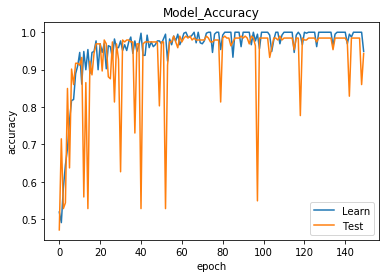

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

def gen_mean (curve):
    mean = [0]* len(curve)
    mean[0] = curve[0]
    for i in range(1,len(curve)):
        mean[i] = ((mean[i-1] )*i + out[i])/(i+1)
    return mean
from scipy.ndimage.filters import gaussian_filter1d


plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model_Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Learn', 'Test'], loc='lower right')
plt.savefig('./150_epoch_accuracy_new_data_Manuel')

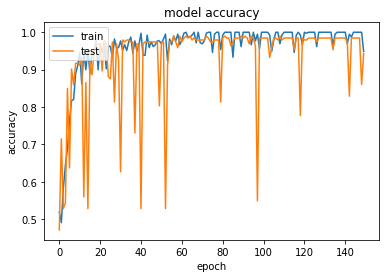

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./model_accuracy_40Epoch_scaled',quality=100,)

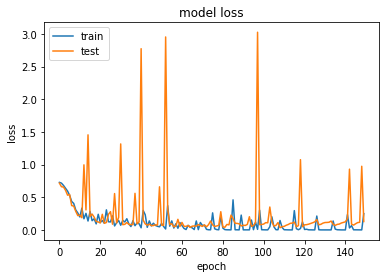

In [15]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('./model_loss_40Epoch_scaled')

In [38]:
model_manuel = load_model('model_manuel_good_performance.h5')
model_giovanni = load_model('model_giovanni_good_performance.h5')
model_dario_reloaded = load_model("model_dario_good_performance.h5")
model_antonio_reloaded = load_model('model_antonio_good_performance.h5')




In [17]:
x, y = xy_data(labelled_data_g)
x1, y1, = xy_data(labelled_data_d)
out_dario_reloaded = model_dario_reloaded.evaluate(x, y)
out_dario_reloaded2 = model_dario_reloaded.evaluate(x1, y1)

print(out_dario_reloaded)
print(out_dario_reloaded2)

35/35 [==============================] - 1s 27ms/step
[1.5159874038291787, 0.8642384105960265]
[12.269071933201381, 0.0]


In [58]:
from sklearn.metrics import roc_curve

with open(os.path.join(file_path ,'Alessando_1_pad.json'), 'r') as f:
    attack = json.load(f)

attack = np.array(attack)



predict = model_manuel.predict(data_dg).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(label_dg, predict)
#print(model_giovanni.evaluate(data_dg, label_dg))
#print(model_manuel.evaluate(data_dg, label_dg))
#print(model_antonio_reloaded.evaluate(data_dg, label_dg))
#attack


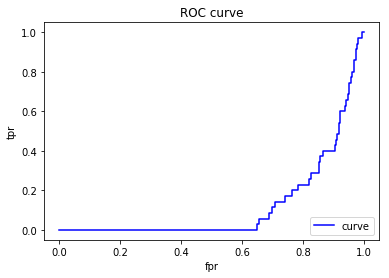

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
roc_auc = metrics.auc(fpr_keras, tpr_keras)

plt.plot(fpr_keras,tpr_keras,'b', label = 'AUC = %0.2f' % roc_auc)
plt.title('ROC curve')
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.legend(['curve'], loc='lower right')
plt.savefig('ROC_curve_Manuel')